## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt
# sns.set_style('whitegrid')
# %matplotlib inline
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
print('TensoFlow Version: ', tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.metrics import Precision, Recall, AUC

TensoFlow Version:  2.16.1


## Reading Data of Class Labels

In [ ]:
path = '/kaggle/input/traffic-signs-classification'
lab = pd.read_csv('/kaggle/input/traffic-signs-classification/labels.csv')

## Reading Image Data

In [ ]:
d = dict()
class_labels = dict()
for dirs in os.listdir(path + '/myData'):
    count = len(os.listdir(path+'/myData/'+dirs))
    d[dirs +' : '+ lab[lab.ClassId == int(dirs)].values[0][1]] = count
    class_labels[int(dirs)] = lab[lab.ClassId == int(dirs)].values[0][1]

plt.figure(figsize = (20, 50))
sns.barplot(y = list(d.keys()), x = list(d.values()), palette = 'Set3')
plt.ylabel('Label')
plt.xlabel('Count of Samples/Observations');

plt.savefig('output_plot.png', bbox_inches='tight')
plt.show()

In [ ]:
img_rows, img_cols = 32, 32
img_channels = 3
nb_classes = len(class_labels.keys())

datagen = ImageDataGenerator(
)
data = datagen.flow_from_directory('/kaggle/input/traffic-signs-classification/myData',
                                    target_size=(32, 32),
                                    batch_size=73139,
                                    class_mode='categorical',
                                    shuffle=True)

In [6]:
X , y = data.next()

In [7]:
print(f"Data Shape   :{X.shape}\nLabels shape :{y.shape}")

Data Shape   :(73139, 32, 32, 3)
Labels shape :(73139, 43)


## Sample Images of Dataset

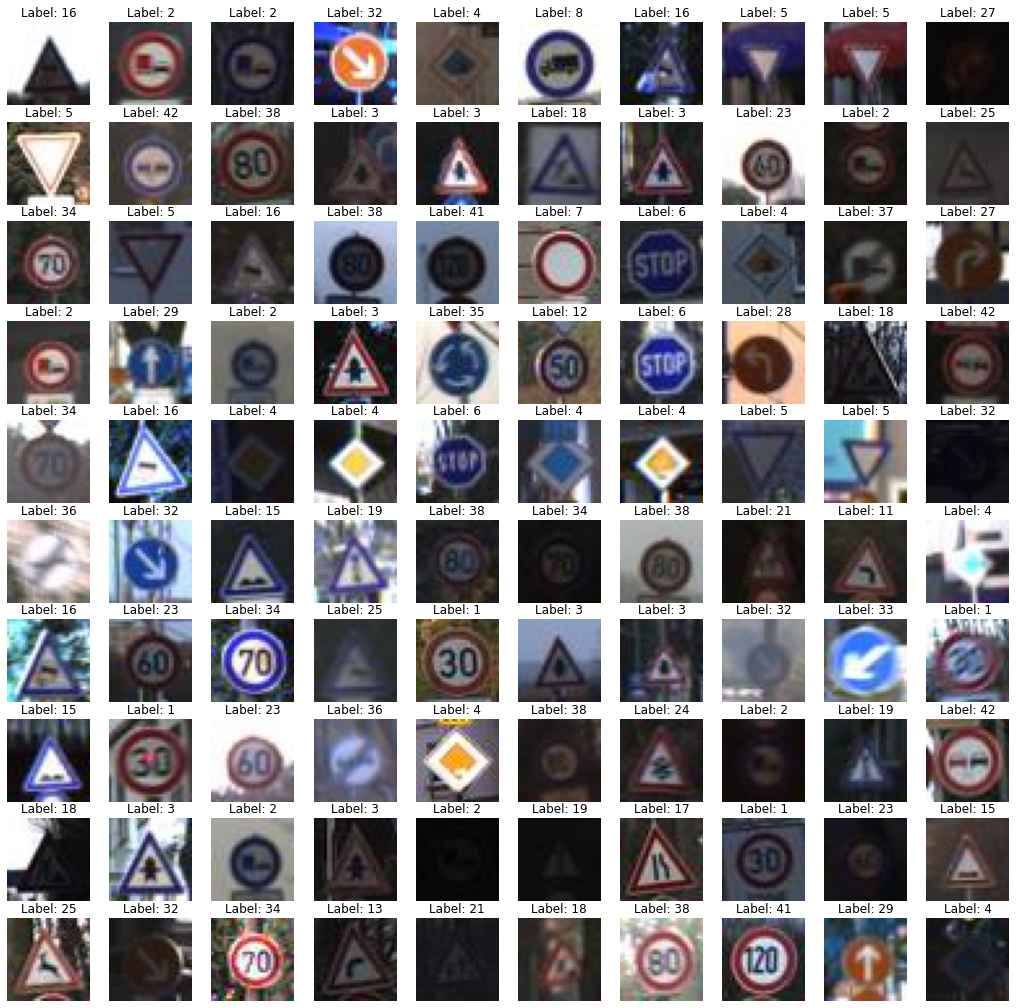

In [7]:
fig, axes = plt.subplots(10,10, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X.shape[0])
    ax.imshow(X[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Label: '+str(np.argmax(y[r])))

## Dividing data into **train** and **test** in the split percentage of 80:20

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)

In [10]:
print("Train Shape: {}\nTest Shape : {}".format(X_train.shape, X_test.shape))

Train Shape: (58511, 32, 32, 3)
Test Shape : (14628, 32, 32, 3)


## Customising ResNet50 model  

In [2]:
def obtain_input_shape(
    input_shape,
    default_size,
    min_size,
    data_format,
    require_flatten,
    weights=None,
):
    if weights != "imagenet" and input_shape and len(input_shape) == 3:
        if data_format == "channels_first":
            correct_channel_axis = 1 if len(input_shape) == 4 else 0
            if input_shape[correct_channel_axis] not in {1, 3}:
                warnings.warn(
                    "This model usually expects 1 or 3 input channels. "
                    "However, it was passed an input_shape "
                    f"with {input_shape[0]} input channels.",
                    stacklevel=2,
                )
            default_shape = (input_shape[0], default_size, default_size)
        else:
            if input_shape[-1] not in {1, 3}:
                warnings.warn(
                    "This model usually expects 1 or 3 input channels. "
                    "However, it was passed an input_shape "
                    f"with {input_shape[-1]} input channels.",
                    stacklevel=2,
                )
            default_shape = (default_size, default_size, input_shape[-1])
    else:
        if data_format == "channels_first":
            default_shape = (3, default_size, default_size)
        else:
            default_shape = (default_size, default_size, 3)
    if input_shape:
        if data_format == "channels_first":
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        "`input_shape` must be a tuple of three integers."
                    )
                if input_shape[0] != 3 and weights == "imagenet":
                    raise ValueError(
                        "The input must have 3 channels; Received "
                        f"`input_shape={input_shape}`"
                    )
                if (
                    input_shape[1] is not None and input_shape[1] < min_size
                ) or (input_shape[2] is not None and input_shape[2] < min_size):
                    raise ValueError(
                        f"Input size must be at least {min_size}"
                        f"x{min_size}; Received: "
                        f"input_shape={input_shape}"
                    )
        else:
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        "`input_shape` must be a tuple of three integers."
                    )
                if input_shape[-1] != 3 and weights == "imagenet":
                    raise ValueError(
                        "The input must have 3 channels; Received "
                        f"`input_shape={input_shape}`"
                    )
                if (
                    input_shape[0] is not None and input_shape[0] < min_size
                ) or (input_shape[1] is not None and input_shape[1] < min_size):
                    raise ValueError(
                        "Input size must be at least "
                        f"{min_size}x{min_size}; Received: "
                        f"input_shape={input_shape}"
                    )
    else:
        if require_flatten:
            input_shape = default_shape
        else:
            if data_format == "channels_first":
                input_shape = (3, None, None)
            else:
                input_shape = (None, None, 3)
    if require_flatten:
        if None in input_shape:
            raise ValueError(
                "If `include_top` is True, "
                "you should specify a static `input_shape`. "
                f"Received: input_shape={input_shape}"
            )
    return input_shape


In [3]:
import tensorflow.keras.backend as backend
import tensorflow.keras.layers as layers

def ResNet(
    stack_fn,
    preact,
    use_bias,
    model_name="resnet",
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):

    if not (weights in {"imagenet", None} or file_utils.exists(weights)):
        raise ValueError(
            "The `weights` argument should be either "
            "`None` (random initialization), 'imagenet' "
            "(pre-training on ImageNet), "
            "or the path to the weights file to be loaded.  Received: "
            f"weights={weights}"
        )

    if weights == "imagenet" and include_top and classes != 1000:
        raise ValueError(
            "If using `weights='imagenet'` with `include_top=True`, "
            "`classes` should be 1000.  "
            f"Received classes={classes}"
        )

    # Determine proper input shape
    input_shape = obtain_input_shape(
        input_shape,
        default_size=224,
        min_size=32,
        data_format=backend.image_data_format(),
        require_flatten=include_top,
        weights=weights,
    )

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    if backend.image_data_format() == "channels_last":
        bn_axis = 3
    else:
        bn_axis = 1

    x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)), name="conv1_pad")(
        img_input
    )
    x = layers.Conv2D(64, 7, strides=2, use_bias=use_bias, name="conv1_conv")(x)

    if not preact:
        x = layers.BatchNormalization(
            axis=bn_axis, epsilon=1.001e-5, name="conv1_bn"
        )(x)
        x = layers.Activation("relu", name="conv1_relu")(x)

    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name="pool1_pad")(x)
    x = layers.MaxPooling2D(3, strides=2, name="pool1_pool")(x)

    x = stack_fn(x)

    if preact:
        x = layers.BatchNormalization(
            axis=bn_axis, epsilon=1.001e-5, name="post_bn"
        )(x)
        x = layers.Activation("relu", name="post_relu")(x)

    if include_top:
        x = layers.GlobalAveragePooling2D(name="avg_pool")(x)

        # Validate activation for the classifier layer
#         imagenet_utils.validate_activation(classifier_activation, weights)

        x = layers.Dense(
            classes, activation=classifier_activation, name="predictions"
        )(x)
    else:
        if pooling == "avg":
            x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        elif pooling == "max":
            x = layers.GlobalMaxPooling2D(name="max_pool")(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = operation_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = tf.keras.Model(inputs, x, name=model_name)

    # Load weights.
    if (weights == "imagenet") and (model_name in WEIGHTS_HASHES):
        if include_top:
            file_name = model_name + "_weights_tf_dim_ordering_tf_kernels.h5"
            file_hash = WEIGHTS_HASHES[model_name][0]
        else:
            file_name = (
                model_name + "_weights_tf_dim_ordering_tf_kernels_notop.h5"
            )
            file_hash = WEIGHTS_HASHES[model_name][1]
        weights_path = file_utils.get_file(
            file_name,
            BASE_WEIGHTS_PATH + file_name,
            cache_subdir="models",
            file_hash=file_hash,
        )
        model.load_weights(weights_path)
    elif weights is not None:
        model.load_weights(weights)

    return model

In [4]:
def residual_block_v1(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):

    if backend.image_data_format() == "channels_last":
        bn_axis = 3
    else:
        bn_axis = 1

    if conv_shortcut:
        shortcut = layers.Conv2D(
            4 * filters, 1, strides=stride, name=name + "_0_conv"
        )(x)
        shortcut = layers.BatchNormalization(
            axis=bn_axis, epsilon=1.001e-5, name=name + "_0_bn"
        )(shortcut)
    else:
        shortcut = x

    x = layers.Conv2D(filters, 1, strides=stride, name=name + "_1_conv")(x)
    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name=name + "_1_bn"
    )(x)
    x = layers.Activation("relu", name=name + "_1_relu")(x)

    x = layers.Conv2D(
        filters, kernel_size, padding="SAME", name=name + "_2_conv"
    )(x)
    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name=name + "_2_bn"
    )(x)
    x = layers.Activation("relu", name=name + "_2_relu")(x)

    x = layers.Conv2D(4 * filters, 1, name=name + "_3_conv")(x)
    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name=name + "_3_bn"
    )(x)

    x = layers.Add(name=name + "_add")([shortcut, x])
    x = layers.Activation("relu", name=name + "_out")(x)
    return x


def stack_residual_blocks_v1(x, filters, blocks, stride1=2, name=None):
    x = residual_block_v1(x, filters, stride=stride1, name=name + "_block1")
    for i in range(2, blocks + 1):
        x = residual_block_v1(
            x, filters, conv_shortcut=False, name=name + "_block" + str(i)
        )
    return x


def residual_block_v2(x, filters, kernel_size=3, stride=1, conv_shortcut=False, name=None):

    if backend.image_data_format() == "channels_last":
        bn_axis = 3
    else:
        bn_axis = 1

    preact = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name=name + "_preact_bn"
    )(x)
    preact = layers.Activation("relu", name=name + "_preact_relu")(preact)

    if conv_shortcut:
        shortcut = layers.Conv2D(
            4 * filters, 1, strides=stride, name=name + "_0_conv"
        )(preact)
    else:
        shortcut = (
            layers.MaxPooling2D(1, strides=stride)(x) if stride > 1 else x
        )

    x = layers.Conv2D(
        filters, 1, strides=1, use_bias=False, name=name + "_1_conv"
    )(preact)
    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name=name + "_1_bn"
    )(x)
    x = layers.Activation("relu", name=name + "_1_relu")(x)

    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + "_2_pad")(x)
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=stride,
        use_bias=False,
        name=name + "_2_conv",
    )(x)
    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name=name + "_2_bn"
    )(x)
    x = layers.Activation("relu", name=name + "_2_relu")(x)

    x = layers.Conv2D(4 * filters, 1, name=name + "_3_conv")(x)
    x = layers.Add(name=name + "_out")([shortcut, x])
    return x


def stack_residual_blocks_v2(x, filters, blocks, stride1=2, name=None):
    x = residual_block_v2(x, filters, conv_shortcut=True, name=name + "_block1")
    for i in range(2, blocks):
        x = residual_block_v2(x, filters, name=name + "_block" + str(i))
    x = residual_block_v2(
        x, filters, stride=stride1, name=name + "_block" + str(blocks)
    )
    return x

def ResNet50(
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):

    def stack_fn(x):
        x = stack_residual_blocks_v1(x, 64, 3, stride1=1, name="conv2")
        x = stack_residual_blocks_v1(x, 128, 4, name="conv3")
        x = stack_residual_blocks_v1(x, 256, 6, name="conv4")
        return stack_residual_blocks_v1(x, 512, 3, name="conv5")

    return ResNet(
        stack_fn,
        False,
        True,
        "resnet50",
        False,
        None,
        None,
        input_shape,
        pooling,
        classes,
        classifier_activation=classifier_activation,
    )

def ResNet101(
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):

    def stack_fn(x):
        x = stack_residual_blocks_v1(x, 64, 3, stride1=1, name="conv2")
        x = stack_residual_blocks_v1(x, 128, 4, name="conv3")
        x = stack_residual_blocks_v1(x, 256, 23, name="conv4")
        return stack_residual_blocks_v1(x, 512, 3, name="conv5")

    return ResNet(
        stack_fn,
        False,
        True,
        "resnet101",
        False,
        None,
        None,
        input_shape,
        pooling,
        classes,
        classifier_activation=classifier_activation,
    )

In [5]:
def get_model():
    resnet = ResNet101(input_shape=(32,32,3))
    
    x = resnet.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(43, activation= 'softmax')(x)
    model = Model(inputs = resnet.input, outputs = predictions)
    
    return model

In [16]:
model = get_model()

In [ ]:
model.summary()

## Visualising Model Architecture

In [ ]:
plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=350)

## Compiling the Model

In [7]:
from tensorflow.keras import backend as K

class PrecisionMetric(tf.keras.metrics.Metric):
    def __init__(self, name='precision', **kwargs):
        super(PrecisionMetric, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.predicted_positives = self.add_weight(name='pp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        
        self.true_positives.assign_add(true_positives)
        self.predicted_positives.assign_add(predicted_positives)

    def result(self):
        return self.true_positives / (self.predicted_positives + K.epsilon())

    def reset_states(self):
        self.true_positives.assign(0)
        self.predicted_positives.assign(0)

class RecallMetric(tf.keras.metrics.Metric):
    def __init__(self, name='recall', **kwargs):
        super(RecallMetric, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.possible_positives = self.add_weight(name='pp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        self.true_positives.assign_add(true_positives)
        self.possible_positives.assign_add(possible_positives)

    def result(self):
        return self.true_positives / (self.possible_positives + K.epsilon())

    def reset_states(self):
        self.true_positives.assign(0)
        self.possible_positives.assign(0)

class F1ScoreMetric(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1ScoreMetric, self).__init__(name=name, **kwargs)
        self.precision_metric = PrecisionMetric()
        self.recall_metric = RecallMetric()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision_metric.update_state(y_true, y_pred, sample_weight)
        self.recall_metric.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision_metric.result()
        recall = self.recall_metric.result()
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.precision_metric.reset_states()
        self.recall_metric.reset_states()

In [55]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', PrecisionMetric(), RecallMetric(), F1ScoreMetric()])

## Creating Callbacks

In [27]:
model_check = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=15, verbose=0, mode='max', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

csv_logger = CSVLogger('train_log.csv', separator=',')

## Fitting Model with Data

In [56]:
n_epochs = 100
history =  model.fit(X_train, y_train,  batch_size = 32, epochs = n_epochs, verbose = 1, 
              validation_data = (X_test, y_test), callbacks = [model_check, early, reduce_lr, csv_logger])

Train on 58511 samples, validate on 14628 samples
Epoch 1/100
58511/58511 [==============================] - 150s 3ms/sample - loss: 4.6324 - accuracy: 0.0941 - precision: 0.0863 - recall: 0.0034 - f1_score: 0.0065 - val_loss: 12.8873 - val_accuracy: 0.0431 - val_precision: 0.0901 - val_recall: 0.0245 - val_f1_score: 0.0385
Epoch 2/100
58511/58511 [==============================] - 133s 2ms/sample - loss: 3.8868 - accuracy: 0.1914 - precision: 0.4373 - recall: 0.0442 - f1_score: 0.0803 - val_loss: 4.5506 - val_accuracy: 0.1588 - val_precision: 0.5267 - val_recall: 0.0304 - val_f1_score: 0.0574
Epoch 3/100
58511/58511 [==============================] - 135s 2ms/sample - loss: 2.5815 - accuracy: 0.4410 - precision: 0.6697 - recall: 0.2631 - f1_score: 0.3778 - val_loss: 71.6976 - val_accuracy: 0.6075 - val_precision: 0.7573 - val_recall: 0.4747 - val_f1_score: 0.5836
Epoch 4/100
58511/58511 [==============================] - 136s 2ms/sample - loss: 2.0556 - accuracy: 0.5538 - precision: 0

In [57]:
model.save('TSC_model.h5')

In [58]:
loss, acc = model.evaluate(X_test, y_test)
print('Accuracy: ', acc, '\nLoss    : ', loss)

14628/14628 [==============================] - 11s 729us/sample - loss: 0.0132 - accuracy: 0.9977 - precision: 0.9978 - recall: 0.9975 - f1_score: 0.9977


ValueError: too many values to unpack (expected 2)

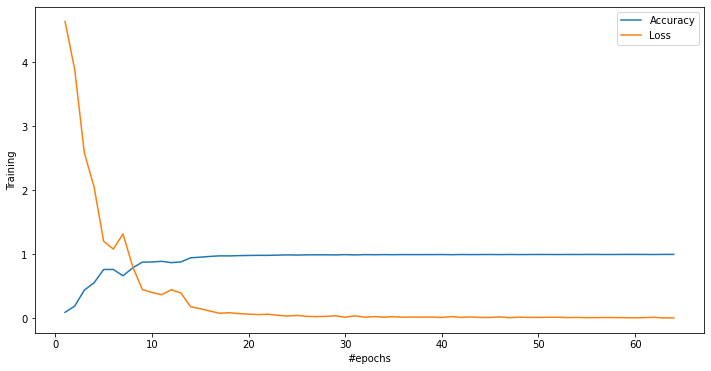

In [59]:
q = len(list(history.history['loss']))
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Accuracy')
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Loss')
plt.xlabel('#epochs')
plt.ylabel('Training')
plt.legend();

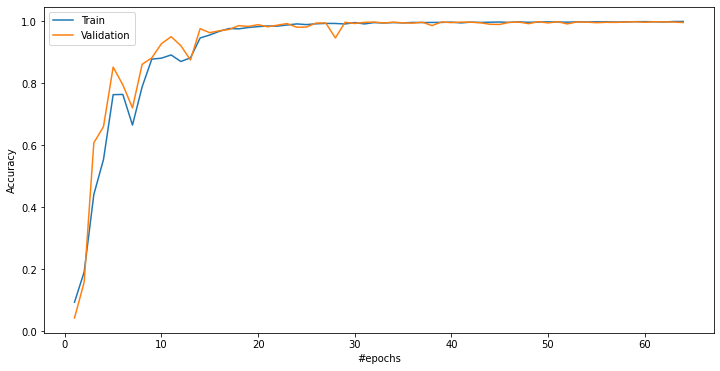

In [60]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Train')
sns.lineplot(x = range(1, 1+q), y = history.history['val_accuracy'], label = 'Validation')
plt.xlabel('#epochs')
plt.ylabel('Accuracy')
plt.legend();

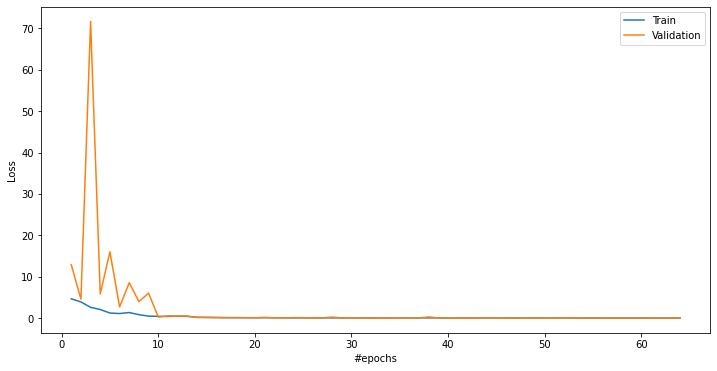

In [61]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Train')
sns.lineplot(x = range(1, 1+q), y = history.history['val_loss'], label = 'Validation')
plt.xlabel('#epochs')
plt.ylabel('Loss')
plt.legend();

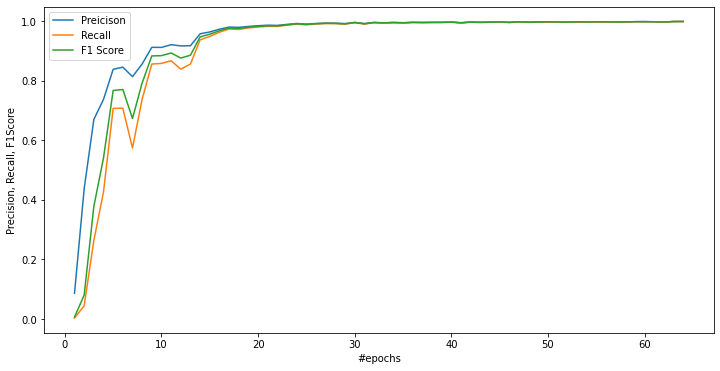

In [64]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['precision'], label = 'Preicison')
sns.lineplot(x = range(1, 1+q), y = history.history['recall'], label = 'Recall')
sns.lineplot(x = range(1, 1+q), y = history.history['f1_score'], label = 'F1 Score')
plt.xlabel('#epochs')
plt.ylabel('Precision, Recall, F1Score')
plt.legend();

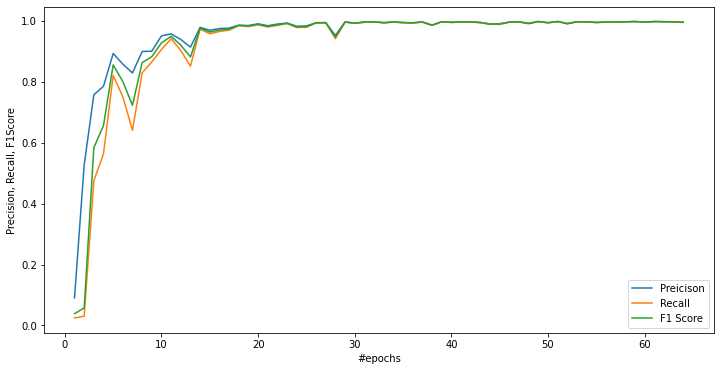

In [68]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['val_precision'], label = 'Preicison')
sns.lineplot(x = range(1, 1+q), y = history.history['val_recall'], label = 'Recall')
sns.lineplot(x = range(1, 1+q), y = history.history['val_f1_score'], label = 'F1 Score')
plt.xlabel('#epochs')
plt.ylabel('Precision, Recall, F1Score')
plt.legend();

In [67]:
import json

history_dict = {key: [float(val) for val in values] for key, values in history.history.items()}
with open('training_history.json', 'w') as json_file:
    json.dump(history_dict, json_file)

## Predict class labels of the test data

In [62]:
%%time
pred = np.argmax(model.predict(X_test), axis = 1)

CPU times: user 12.3 s, sys: 219 ms, total: 12.5 s
Wall time: 12 s


## Classification Report

In [69]:
labels = [class_labels[i] for i in range(43)]
print(classification_report(np.argmax(y_test, axis = 1), pred, target_names = labels))

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       1.00      1.00      1.00        88
                              Speed limit (30km/h)       1.00      1.00      1.00       947
                              Speed limit (50km/h)       1.00      1.00      1.00       721
                              Speed limit (60km/h)       1.00      0.99      0.99       483
                              Speed limit (70km/h)       1.00      1.00      1.00       803
                              Speed limit (80km/h)       1.00      1.00      1.00       854
                       End of speed limit (80km/h)       1.00      1.00      1.00       291
                             Speed limit (100km/h)       1.00      1.00      1.00       240
                             Speed limit (120km/h)       0.98      1.00      0.99       176
                                        No passing       1.00      1.00      1.

## Confusion Matrix

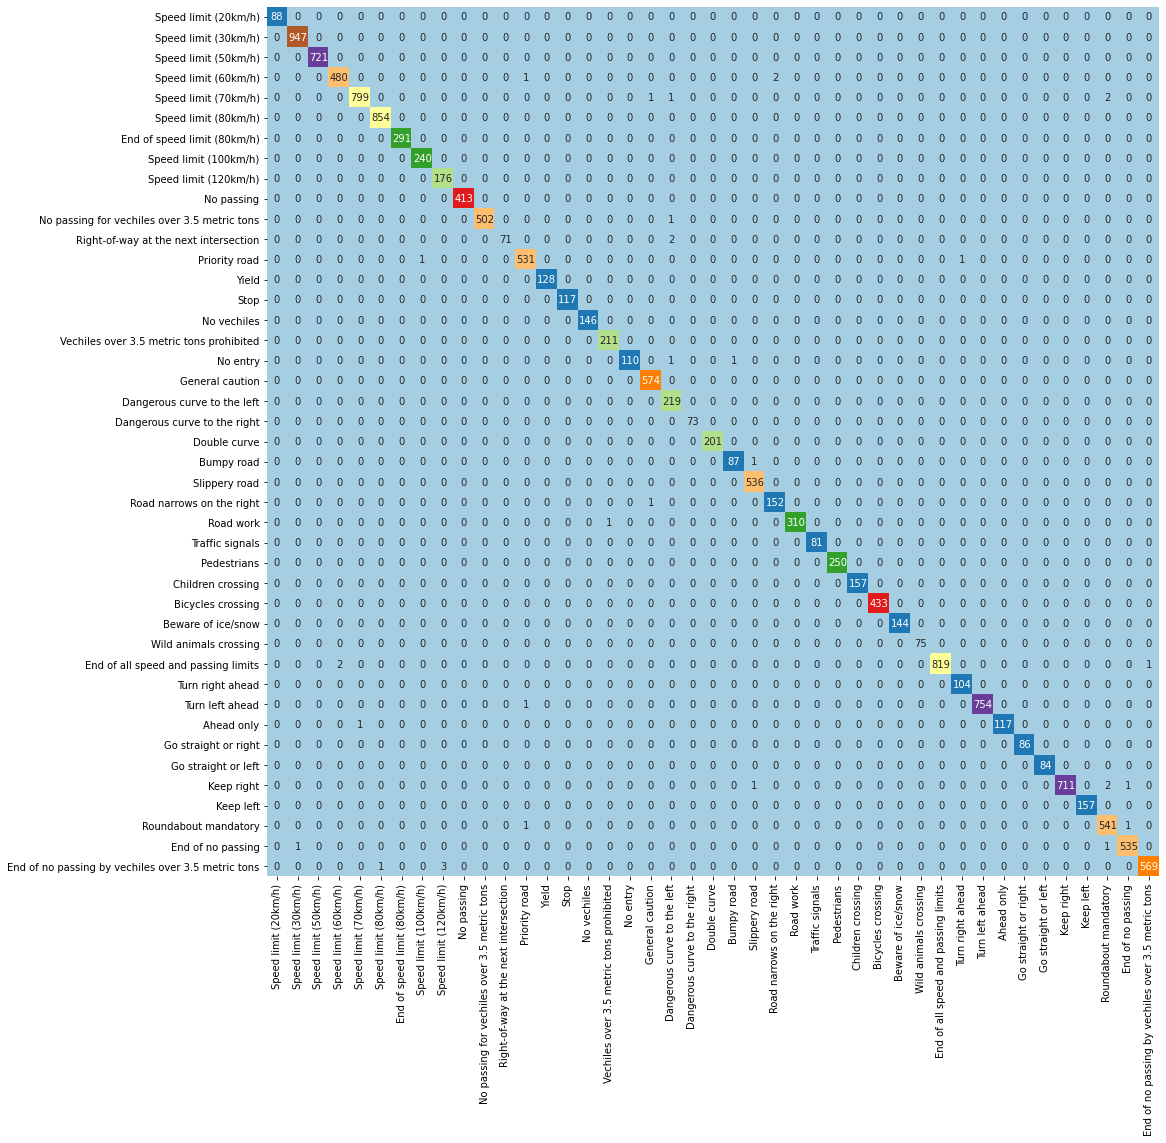

In [70]:
cmat = confusion_matrix(np.argmax(y_test, axis=1), pred)
plt.figure(figsize=(16,16))
sns.heatmap(cmat, annot = True, cbar = False, cmap='Paired', fmt="d", xticklabels=labels, yticklabels=labels);

## Classwise Accuracy

In [71]:
classwise_acc = cmat.diagonal()/cmat.sum(axis=1) * 100 
cls_acc = pd.DataFrame({'Class_Label':[class_labels[i] for i in range(43)], 'Accuracy': classwise_acc.tolist()}, columns = ['Class_Label', 'Accuracy'])
cls_acc.style.format({"Accuracy": "{:,.2f}",}).hide_index().bar(subset=["Accuracy"], color='tomato')

Class_Label,Accuracy
Speed limit (20km/h),100.00
Speed limit (30km/h),100.00
Speed limit (50km/h),100.00
Speed limit (60km/h),99.38
Speed limit (70km/h),99.50
Speed limit (80km/h),100.00
End of speed limit (80km/h),100.00
Speed limit (100km/h),100.00
Speed limit (120km/h),100.00
No passing,100.00


## Finally, Lets see the predictions of **unseen data**

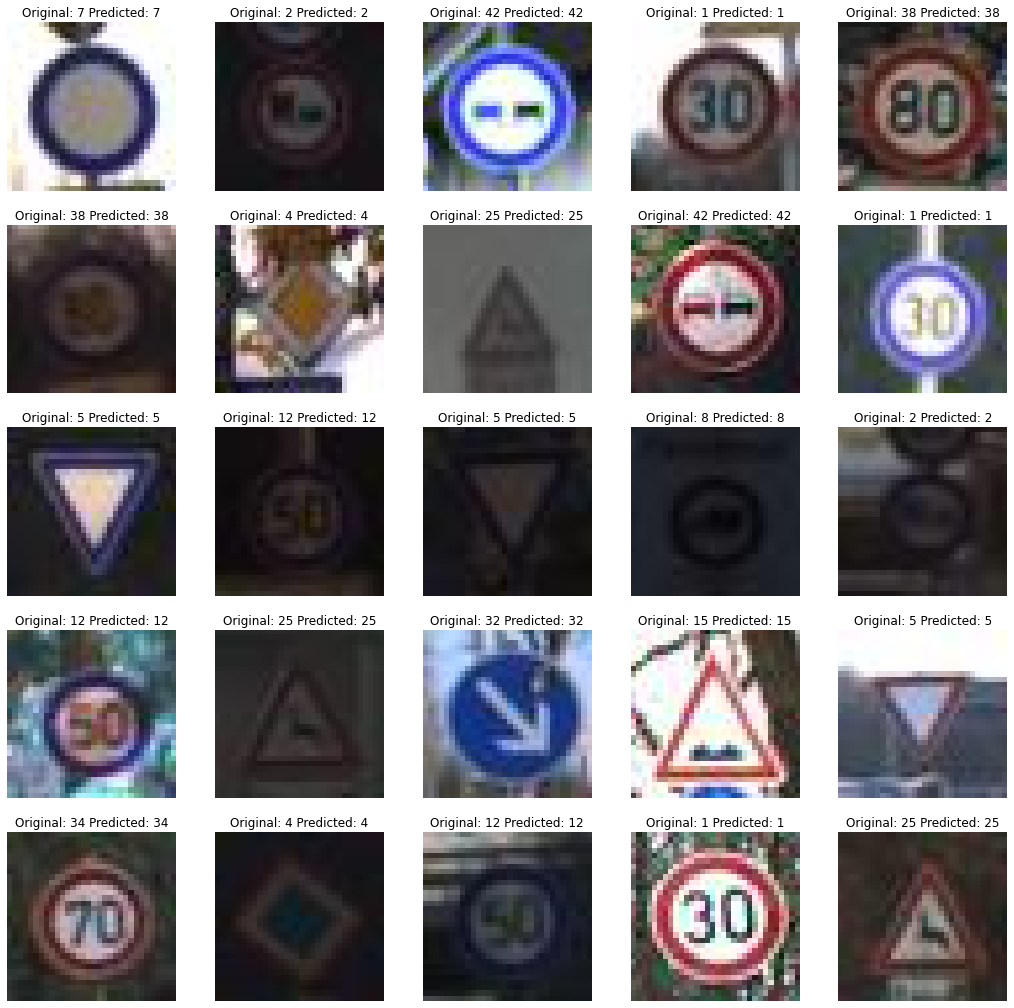

In [72]:
fig, axes = plt.subplots(5,5, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X_test.shape[0])
    ax.imshow(X_test[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Original: {} Predicted: {}'.format(np.argmax(y_test[r]), np.argmax(model.predict(X_test[r].reshape(1, 32, 32, 3)))))

In [8]:
model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', PrecisionMetric(), RecallMetric(), F1ScoreMetric()])

model.load_weights('best_model.h5')

In [9]:
import tensorflow as tf
from PIL import Image
import requests
from io import BytesIO
import numpy as np

def load_and_preprocess_image(url, target_size):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize(target_size)
    img_array = np.array(img, dtype='float32')
    # if img_array.shape[-1] == 4:
    #     img_array = img_array[..., :3]
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [13]:
image_url = 'https://th.bing.com/th/id/R.4ae82a95b1fd7b033ee97f0d8a7da3fc?rik=BWrlpz4kRT2N9w&riu=http%3a%2f%2fwww.photos-public-domain.com%2fwp-content%2fuploads%2f2010%2f10%2fstop_sign.jpg&ehk=gDj8fOwycKKqSGN4V8yc9rLuc8WE%2bSoh47NV50FinJo%3d&risl=&pid=ImgRaw&r=0'
target_size = (32, 32)
preprocessed_image = load_and_preprocess_image(image_url, target_size)

In [19]:
# image = Image.open('OIP (11).jpg')
# preprocessed_image = load_and_preprocess_image(image_url, target_size)

In [20]:
predictions = model.predict(preprocessed_image)
predicted_class = np.argmax(predictions, axis=1)

print(f'Predicted class: {predicted_class[0]}')

class_labels = {
     0: 'Speed limit (20km/h)',
     1: 'Speed limit (30km/h)',
     2: 'No passing for vechiles over 3.5 metric tons',
     3: 'Right-of-way at the next intersection',
     4: 'Priority road',
     5: 'Yield',
     6: 'Stop',
     7: 'No vechiles',
     8: 'Vechiles over 3.5 metric tons prohibited',
     9: 'No entry',
     10: 'General caution',
     11: 'Dangerous curve to the left',
     12: 'Speed limit (50km/h)',
     13: 'Dangerous curve to the right',
     14: 'Double curve',
     15: 'Bumpy road',
     16: 'Slippery road',
     17: 'Road narrows on the right',
     18: 'Road work',
     19: 'Traffic signals',
     20: 'Pedestrians',
     21: 'Children crossing',
     22: 'Bicycles crossing',
     23: 'Speed limit (60km/h)',
     24: 'Beware of ice/snow',
     25: 'Wild animals crossing',
     26: 'End of all speed and passing limits',
     27: 'Turn right ahead',
     28: 'Turn left ahead',
     29: 'Ahead only',
     30: 'Go straight or right',
     31: 'Go straight or left',
     32: 'Keep right',
     33: 'Keep left',
     34: 'Speed limit (70km/h)',
     35: 'Roundabout mandatory',
     36: 'End of no passing',
     37: 'End of no passing by vechiles over 3.5 metric tons',
     38: 'Speed limit (80km/h)',
     39: 'End of speed limit (80km/h)',
     40: 'Speed limit (100km/h)',
     41: 'Speed limit (120km/h)',
     42: 'No passing'
}
predicted_label = class_labels[predicted_class[0]]
print(f'Predicted label: {predicted_label}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted class: 6
Predicted label: Stop
